# Análisis Encuesta Origen-Destino -  Limpieza de Datos & Cálculo de Indicadores

## Brasil - Sao Paulo - 2017

#### Elaborado por Paula Vásquez-Henríquez, Ariel López, Genaro Cuadros, Exequiel Gaete, Alba Vásquez y Juan Correa

Importando módulos y funciones de trabajo

In [2]:
!pip3 uninstall matplotlib -y

In [3]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [4]:
!git clone https://github.com/zorzalerrante/aves.git aves_git

Cloning into 'aves_git'...
remote: Enumerating objects: 884, done.
remote: Total 884 (delta 0), reused 0 (delta 0), pack-reused 884
Receiving objects: 100% (884/884), 166.05 MiB | 20.28 MiB/s, done.
Resolving deltas: 100% (348/348), done.
Checking out files: 100% (281/281), done.


In [ ]:
!mamba env update --name base --file aves_git/environment-colab.yml

conda-forge/noarch       [] (00m:00s) 
conda-forge/noarch       [] (00m:00s) 131 KB / ?? (428.11 KB/s)
conda-forge/noarch       [] (00m:00s) 131 KB / ?? (428.11 KB/s)
pkgs/main/linux-64       [] (00m:00s) 
conda-forge/noarch       [] (00m:00s) 131 KB / ?? (428.11 KB/s)
pkgs/main/linux-64       [] (00m:00s) 176 KB / ?? (578.34 KB/s)
conda-forge/noarch       [] (00m:00s) 131 KB / ?? (428.11 KB/s)
pkgs/main/linux-64       [] (00m:00s) 176 KB / ?? (578.34 KB/s)
pkgs/main/noarch         [] (00m:00s) 
conda-forge/noarch       [] (00m:00s) 131 KB / ?? (428.11 KB/s)
pkgs/main/linux-64       [] (00m:00s) 176 KB / ?? (578.34 KB/s)
pkgs/main/noarch         [] (00m:00s) 176 KB / ?? (577.49 KB/s)
conda-forge/noarch       [] (00m:00s) 131 KB / ?? (428.11 KB/s)
pkgs/main/linux-64       [] (00m:00s) 176 KB / ?? (578.34 KB/s)
pkgs/main/noarch         [] (00m:00s) 176 KB / ?? (577.49 KB/s)
pkgs/r/linux-64          [] (00m:00s) 
conda-forge/noarch       [] (00m:00s) 131 KB / ?? (428.11 KB/s)
pkgs/main/li

In [ ]:
!pip3 install geopandas
!pip3 install haversine
!pip3 install pandasql
!pip3 install pyreadstat
!pip3 install seaborn

     |████████████████████████████████| 1.6 MB 19.3 MB/s 
     |████████████████████████████████| 150 kB 70.7 MB/s 
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26818 sha256=db8c5704535272681cdb4080b7382945dc8abc2fc81dd864940f8a50a77075c6
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql
     |████████████████████████████████| 2.4 MB 13.3 MB/s 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import warnings
import haversine as hs
import shapely
from sklearn.preprocessing import normalize
import datetime
import pyreadstat
from pandasql import sqldf

ModuleNotFoundError: ignored

In [ ]:
def convert_datatype(df, lista_columnas):
    for column in lista_columnas:
        df[column] = df[column].str.replace(",", ".").astype(float)
    return df

In [ ]:
def imputar_coordenadas_centroide_zat(df, latitud, longitud, zat):
    mask = df[latitud].isnull() | df[longitud].isnull()
    ids_latitud_vacia = df[mask].index
    working_df = pd.merge(df, city_shp[['zona_num_n', 'x_coord', 'y_coord']], left_on=zat, right_on='zona_num_n', how='left')
    df.loc[ids_latitud_vacia, latitud] = working_df.loc[ids_latitud_vacia, 'y_coord']
    df.loc[ids_latitud_vacia, longitud] = working_df.loc[ids_latitud_vacia, 'x_coord']
    return df

In [ ]:
def decode_column(df, fname, col_name, index_col='id', value_col=None, sep=';', encoding='utf-8'):
    '''
    param :df: DataFrame del que leeremos una columna.
    param :fname: nombre del archivo que contiene los valores a decodificar.
    param :col_name: nombre de la columna que queremos decodificar.
    param :index_col: nombre de la columna en el archivo @fname que tiene los índices que codifican @col_name
    param :value_col: nombre de la columna en el archivo @fname que tiene los valores decodificados
    param :sep: carácter que separa los valores en @fname. 
    param :encoding: identificación del _character set_ que utiliza el archivo. Usualmente es utf-8, si no funciona,
                     se puede probar con iso-8859-1.
    '''
    if value_col is None:
        value_col = 'value'
        
    values_df = pd.read_csv(fname, sep=sep, index_col=index_col, names=[index_col, value_col], header=0,
                            dtype={index_col: np.float64}, encoding=encoding)
    
    src_df = df.loc[:,(col_name,)]
    
    return src_df.join(values_df, on=col_name)[value_col]

In [ ]:
def mapear_vacios(row, column):
    if pd.isna(row[column])==True:
        return 'Sin información'
    else:
        return row[column]

In [ ]:
def normalize_rows(df):
    return df.pipe(lambda x: pd.DataFrame(normalize(df, axis=1, norm='l1'), columns=df.columns, index=df.index))

In [ ]:
def age_cohorts(row, age_column):
    if row[age_column] < 18:
        return '<18'
    elif row[age_column] <=29 and row[age_column] > 18:
        return '18-29'
    elif row[age_column] <=60 and row[age_column] > 29:
        return '30-60'
    elif row[age_column] > 60 and row[age_column] < 100:
        return '>60'
    else:
        return 'No declarado'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Caracterización de los datos

Los datos utilizados en este cuaderno corresponden a los resultados de la Encuesta Origen-Destino de Sao Paulo, Brasil del 2017. 
A partir de estos datos se calcularan indicadores en tres niveles: de Cantidad de Viajes, de Tiempo de Viajes, y de Distancia de Viajes.

### Importando datos

En esta sección, importamos todos los datos necesarios para el cálculo de indicadores. 
Para el caso de Sao Paulo 2017, los archivos son de SPSS.

Como en muchas de las EOD tenemos data a nivel de:
- Viajes
- Etapas
- Personas
- Hogares

In [ ]:
data_path = '/content/drive/MyDrive/Carpeta compartida (clon Teams)/Ciudades/Sao Paulo/EOD_Sao Paulo/OD 2017'
#data_path = '/Users/pauvasquezh/Dropbox/Proyectos/eod_analysis/Carpeta compartida (clon Teams)/Sao Paulo/EOD_Sao Paulo/OD 2017'

Importamos la matriz de viajes

In [ ]:
# Matriz de viajes
data_viajes_personas, metadata_viajes_personas = pyreadstat.read_sav(data_path + "/Banco de dados/OD_2017.sav", apply_value_formats=True)
data_viajes_personas.head()
#data_viajes = convert_datatype(data_viajes, ["LATITUD_ORIGEN", "LATITUD_DESTINO", "LONGITUD_ORIGEN", "LONGITUD_DESTINO", 'PONDERADOR_CALIBRADO_VIAJES', 'FE_TOTAL', 'FACTOR_AJUSTE_TRANSMILENIO', 'PONDERADOR_CALIBRADO'])

zona   muni_dom  co_dom_x  ...  via_bici tp_estbici id_ordem
0   1.0  São Paulo  333743.0  ...       NaN        NaN      1.0
1   1.0  São Paulo  333743.0  ...       NaN        NaN      2.0
2   1.0  São Paulo  333743.0  ...       NaN        NaN      3.0
3   1.0  São Paulo  333743.0  ...       NaN        NaN      4.0
4   1.0  São Paulo  333743.0  ...       NaN        NaN      5.0

[5 rows x 126 columns]

Esta EOD tiene la particularidad de estar compuesta de una sola tabla que contiene todos los datos integrados: viaje, etapa, persona y hogar.
Es por esto que debemos extraer particularmente la información necesaria para crear dos conjuntos de trabajo: viajes y personas.

In [ ]:
data_viajes_personas.columns

Index(['zona', 'muni_dom', 'co_dom_x', 'co_dom_y', 'id_dom', 'f_dom', 'fe_dom',
       'dom', 'cd_entre', 'data',
       ...
       'duracao', 'modoprin', 'tipvg', 'pag_viag', 'tp_esauto', 'vl_est',
       'pe_bici', 'via_bici', 'tp_estbici', 'id_ordem'],
      dtype='object', length=126)

In [ ]:
# Matriz de viajes
q = "SELECT id_pess, n_viag, fe_via, dia_sem, zona_o, muni_o, co_o_x,co_o_y, zona_d, muni_d, co_d_x, co_d_y, motivo_d, h_saida, min_saida, h_cheg, min_cheg, duracao, modoprin, id_ordem from data_viajes_personas"
data_viajes = sqldf(q, locals())

In [ ]:
# Matriz de personas
q = "SELECT DISTINCT id_pess, fe_pess, criteriobr, sexo from data_viajes_personas"
data_personas = sqldf(q, locals())

Importamos el shapefile que trae las coordenadas de los distritos de Sao Paulo.

In [ ]:
# Shapefile de la ciudad
city_shp = gpd.read_file(data_path + "/Mapas/Shape/Distritos_2017_region.shp")

In [ ]:
city_shp['x_coord'] = city_shp.centroid.x
city_shp['y_coord'] = city_shp.centroid.y

In [ ]:
city_shp.crs

<Projected CRS: EPSG:22523>
Name: Corrego Alegre 1970-72 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - onshore between 48°W and 42°W and south of 15°S.
- bounds: (-48.0, -25.29, -42.0, -15.0)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Corrego Alegre 1970-72
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

### Preparación de los datos

#### Viajes

En esta etapa nos enfocaremos en preparar los datos con respecto a viajes.
En particular, nos enfocamos en limpiar y estandarizar los datos para las columnas que son relevantes para el cálculo de indicadores.


In [ ]:
viajes_df = data_viajes#[selected_columns]

In [ ]:
viajes_df.modoprin.unique()

array(['A pé', 'Metrô', 'Táxi não convencional', None,
       'Ônibus/micro-ônibus/perua do município de São Paulo',
       'Dirigindo automóvel', 'Transporte fretado', 'Táxi convencional',
       'Passageiro de automóvel', 'Transporte escolar', 'Outros', 'Trem',
       'Dirigindo moto', 'Bicicleta', 'Passageiro de moto',
       'Ônibus/micro-ônibus/perua metropolitano',
       'Ônibus/micro-ônibus/perua de outros municípios', 'Monotrilho'],
      dtype=object)

In [ ]:
publico_viaje = ['Metrô', 'Ônibus/micro-ônibus/perua do município de São Paulo', 'Ônibus/micro-ônibus/perua metropolitano',
       'Ônibus/micro-ônibus/perua de outros municípios']
privado_viaje = ['A pé',  'Dirigindo automóvel', 'Transporte fretado', 'Táxi convencional', 'Passageiro de automóvel', 'Transporte escolar', 'Outros', 'Trem',
       'Dirigindo moto', 'Bicicleta', 'Passageiro de moto', 'Monotrilho']
peaton_viaje = ['A pé','Bicicleta']
motorizado_viaje = ['Metrô', 'Ônibus/micro-ônibus/perua do município de São Paulo', 'Ônibus/micro-ônibus/perua metropolitano',
       'Ônibus/micro-ônibus/perua de outros municípios','A pé',  'Dirigindo automóvel', 'Transporte fretado', 'Táxi convencional', 'Passageiro de automóvel', 'Transporte escolar', 'Outros', 'Trem',
       'Dirigindo moto','Passageiro de moto', 'Monotrilho']

In [ ]:
def publico_privado(row, column, publico, privado):
    if row[column] in (publico):
        return 'Público'
    elif row[column] in (privado):
        return 'Privado'
    else:
        return 'Otro'
    
viajes_df['publico_privado'] = viajes_df.apply(lambda row: publico_privado(row, 'modoprin', publico_viaje, privado_viaje), axis=1)

2. Revisamos la cantidad de valores nulos por atributo, para revisar si debemos imputar

In [ ]:
print('Contando valores nulos por atributo')
for column in viajes_df.columns:
    print('{}: {}'.format(column, viajes_df[column].isna().sum()))

Contando valores nulos por atributo
id_pess: 0
n_viag: 25100
fe_via: 25100
dia_sem: 25100
zona_o: 25100
muni_o: 25100
co_o_x: 25100
co_o_y: 25100
zona_d: 25100
muni_d: 25100
co_d_x: 25100
co_d_y: 25100
motivo_d: 25100
h_saida: 25100
min_saida: 25100
h_cheg: 25100
min_cheg: 25100
duracao: 25100
modoprin: 25100
id_ordem: 0
publico_privado: 0


Tenemos muchas filas vacías, así que las dejaremos fuera.

In [ ]:
viajes_df = viajes_df[~viajes_df.n_viag.isna()]

In [ ]:
viajes_df.dia_sem.unique()

array(['Terça-feira', 'Sexta-feira', 'Quinta-feira', 'Segunda-feira',
       'Quarta-feira'], dtype=object)

Esta encuesta solo tiene viajes ocurridos entre Martes y Viernes, por lo que consideraremos todos los viajes como días hábiles.

In [ ]:
viajes_df['DIA_HABIL'] = 'Si'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Identificaremos los viajes hechos en hora pico, como aquellos con horario de salida entre 7am y 9am.

In [ ]:
def pico_habil(row):
    if row['h_saida'] >= 7.0 and row['h_saida'] <= 9.0:
        return'Si'
    else:
        return 'No'
    
viajes_df['PICO_HABIL'] = viajes_df.apply(lambda row: pico_habil(row), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Luego, definiremos un viaje Intrazonal como aquel cuya zona de origen es igual a la zona de destino. De otra manera, es interzonal.

In [ ]:
viajes_df['Intra_Inter'] = viajes_df.apply(lambda row: 'Intra' if row['zona_o'] == row['zona_d'] else 'Inter', axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Calculamos la distancia Manhattan entre las coordenadas de origen y destino del viaje.

In [ ]:
def manhattan_distance(a, b):
    return np.abs(a - b).sum()

In [ ]:
viajes_df['distancia_manhattan'] = viajes_df.apply(lambda row: manhattan_distance(np.array([row['co_o_x'], row['co_o_y']]), np.array([row['co_d_x'], row['co_d_y']])), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
print('Contando valores nulos por atributo')
for column in viajes_df.columns:
    print('{}: {}'.format(column, viajes_df[column].isna().sum()))

Contando valores nulos por atributo
id_pess: 0
n_viag: 0
fe_via: 0
dia_sem: 0
zona_o: 0
muni_o: 0
co_o_x: 0
co_o_y: 0
zona_d: 0
muni_d: 0
co_d_x: 0
co_d_y: 0
motivo_d: 0
h_saida: 0
min_saida: 0
h_cheg: 0
min_cheg: 0
duracao: 0
modoprin: 0
id_ordem: 0
publico_privado: 0
DIA_HABIL: 0
PICO_HABIL: 0
Intra_Inter: 0
distancia_manhattan: 0


Finalmente nos quedamos con 157.992 viajes

In [ ]:
viajes_df.shape

(157992, 25)

#### Personas y Hogares

En esta etapa nos enfocaremos en preparar los datos con respecto a personas.
En particular, nos enfocamos en limpiar y estandarizar los datos para las columnas que son relevantes para el cálculo de indicadores.


In [ ]:
personas_df = data_personas#[selected_columns]

In [ ]:
personas_df.columns

Index(['id_pess', 'fe_pess', 'criteriobr', 'sexo'], dtype='object')

In [ ]:
viajes_personas = pd.merge(viajes_df, personas_df, on=['id_pess'], how='left')

In [ ]:
print('Contando valores nulos por atributo')
for column in viajes_personas.columns:
    print('{}: {}'.format(column, viajes_personas[column].isna().sum()))

Contando valores nulos por atributo
id_pess: 0
n_viag: 0
fe_via: 0
dia_sem: 0
zona_o: 0
muni_o: 0
co_o_x: 0
co_o_y: 0
zona_d: 0
muni_d: 0
co_d_x: 0
co_d_y: 0
motivo_d: 0
h_saida: 0
min_saida: 0
h_cheg: 0
min_cheg: 0
duracao: 0
modoprin: 0
id_ordem: 0
publico_privado: 0
DIA_HABIL: 0
PICO_HABIL: 0
Intra_Inter: 0
distancia_manhattan: 0
fe_pess: 0
criteriobr: 3605
sexo: 0


In [ ]:
viajes_personas.to_csv(data_path + '/viajes_personas_saopaulo_2017.csv', index=False)

### Parte I: Indicadores de Cantidad de Viajes

En esta primera parte, responderemos algunas preguntas respecto a indicadores de cantidades de viajes realizados, en días hábiles de viaje. Para esto, buscaremos responder las siguientes preguntas:

1. ¿Cuál es la tasa promedio de viajes diarios en transporte público por clasificador económico?
2. ¿Cuál es la tasa promedio de viajes diarios en transporte privado por clasificador económico?
3. ¿Cuál es la razón entre los viajes en transporte público y privado por clasificador socioeconómico?
4. ¿Cuál es la distribución/partición modal de los viajes por clasificador socioeconómico?

In [ ]:
print('Cantidad de etapas mapeadas: totales encuesta , total expandido')
viajes_habiles = viajes_personas[viajes_personas.DIA_HABIL=='Si']
print('Total etapas Habiles: {}'.format(viajes_habiles.shape[0]), viajes_habiles['fe_via'].sum())

Cantidad de etapas mapeadas: totales encuesta , total expandido
Total etapas Habiles: 157995 42007124.12276828


Separamos los viajes hábiles de acuerdo a si son privados o publicos.

In [ ]:
viajes_publico_habiles = viajes_habiles[viajes_habiles.modoprin.isin(publico_viaje)]
#viajes_publico_nohabiles = viajes_nohabiles[viajes_nohabiles.MEDIO_PREDOMINANTE.isin(publico_viaje)]

viajes_privado_habiles = viajes_habiles[viajes_habiles.modoprin.isin(privado_viaje)]
#viajes_privado_nohabiles = viajes_nohabiles[viajes_nohabiles.MEDIO_PREDOMINANTE.isin(privado_viaje)]

In [ ]:
def weighted_mean(df, value_column, weighs_column):
    weighted_sum = (df[value_column] * df[weighs_column]).sum()
    return weighted_sum / df[weighs_column].sum()

In [ ]:
def weighted_median(df, val, weight):
    df_sorted = df.sort_values(val)
    cumsum = df_sorted[weight].cumsum()
    cutoff = df_sorted[weight].sum() / 2.
    return df_sorted[cumsum >= cutoff][val].iloc[0]

#### **¿Cuál es la tasa promedio de viajes diarios en transporte público por clasificador económico?**

Las tablas y gráficos muestran los viajes per cápita en trasporte público durante días hábiles, por clasificador socioeconómico.

In [ ]:
from pandasql import sqldf
def calculate_n_viajes_per_capita(df, df_str, agg_columns_str, agg_columns_lst, id_person, person_weight, trip_weight=None):
    q = "SELECT DISTINCT {}, {}, {} FROM {}".format(id_person, agg_columns_str, person_weight, df_str)
    persons = sqldf(q, globals())
    n_personas = persons.groupby(agg_columns_lst).sum()[[person_weight]].reset_index()
    n_personas[agg_columns_lst[0]] = n_personas[agg_columns_lst[0]].astype(str)
    n_viajes = df.groupby(agg_columns_lst).sum()[[trip_weight]].reset_index()
    n_viajes[agg_columns_lst[0]] = n_viajes[agg_columns_lst[0]].astype(str)
    merged = pd.merge(n_personas, n_viajes, on=agg_columns_lst, how='left')
    merged['viajes_per_capita'] = merged[trip_weight] / merged[person_weight]
    return merged

In [ ]:
print('Viajes per cápita en transporte público - Día Hábil')
df = calculate_n_viajes_per_capita(viajes_publico_habiles, "viajes_publico_habiles", "criteriobr", ["criteriobr"], 'id_pess', 'fe_pess', 'fe_via')
df

Viajes per cápita en transporte público - Día Hábil


criteriobr       fe_pess        fe_via  viajes_per_capita
0          A  1.857767e+05  4.335193e+05           2.333551
1         B1  3.396584e+05  7.886714e+05           2.321955
2         B2  1.476843e+06  3.435755e+06           2.326419
3         C1  1.551322e+06  3.630073e+06           2.339987
4         C2  1.075142e+06  2.489527e+06           2.315532
5      D - E  3.021206e+05  7.007075e+05           2.319297

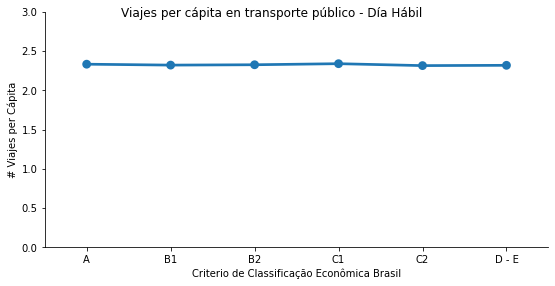

In [ ]:
#fig, ax = plt.subplots(figsize=(8,6))
g = sns.catplot(x="criteriobr", y="viajes_per_capita", 
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Viajes per cápita en transporte público - Día Hábil')
g.set_ylabels('# Viajes per Cápita')
g.set_xlabels('Criterio de Classificação Econômica Brasil')
g.set(ylim=(0,3))

#fig.tight_layout()

No se observa diferencia de viajes realizados en transporte público entre los distintos niveles socioeconómicos.

#### **¿Cuál es la tasa promedio de viajes diarios en transporte privado por clasificador económico?**

Las tablas y gráficos muestran los viajes per cápita en trasporte privado durante días hábiles, por clasificador socioeconómico.

In [ ]:
print('Viajes per cápita en transporte privado - Día Hábil')
df = calculate_n_viajes_per_capita(viajes_privado_habiles, "viajes_privado_habiles", "criteriobr", ["criteriobr"], 'id_pess', 'fe_pess', 'fe_via')
df

Viajes per cápita en transporte privado - Día Hábil


criteriobr       fe_pess        fe_via  viajes_per_capita
0          A  7.923225e+05  2.568455e+06           3.241678
1         B1  9.815541e+05  3.004461e+06           3.060922
2         B2  3.220258e+06  9.299479e+06           2.887805
3         C1  2.754200e+06  7.581027e+06           2.752533
4         C2  1.905935e+06  5.318530e+06           2.790510
5      D - E  5.557893e+05  1.524073e+06           2.742178

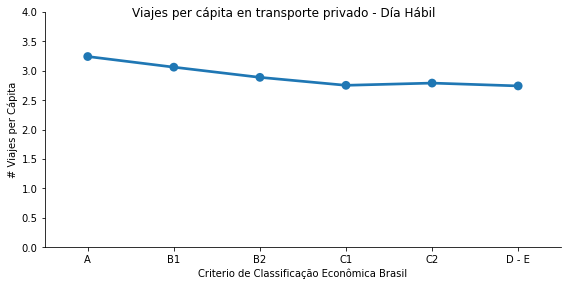

In [ ]:
g = sns.catplot(x="criteriobr", y="viajes_per_capita", 
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Viajes per cápita en transporte privado - Día Hábil')
g.set_ylabels('# Viajes per Cápita')
g.set_xlabels('Criterio de Classificação Econômica Brasil')
g.set(ylim=(0,4))

#fig.tight_layout()

Se observa diferencia de viajes en modo privado en los distintos niveles socioeconómicos, en donde los niveles más vulnerables tienen una cantidad de viajes menor que los niveles más altos. Es decir, los niveles más altos usan más el transporte privado.

#### **¿Cuál es la razón entre los viajes en transporte público y privado por clasificador socioeconómico?**

Las tablas y gráficos a continuación muestran la razón entre los viajes en transporte público y transporte privado durante días hábiles, por clasificador socioeconómico.

In [ ]:
print('Razón entre los viajes en transporte público y privado - Día Hábil')
df = viajes_privado_habiles.groupby(["criteriobr"]).agg(privado_sobre_publico = ('fe_via', 'sum')) / viajes_publico_habiles.groupby(["criteriobr"]).agg(privado_sobre_publico = ('fe_via', 'sum'))
df.reset_index(inplace=True)
df

Razón entre los viajes en transporte público y privado - Día Hábil


criteriobr  privado_sobre_publico
0          A               5.924660
1         B1               3.809522
2         B2               2.706677
3         C1               2.088395
4         C2               2.136361
5      D - E               2.175049

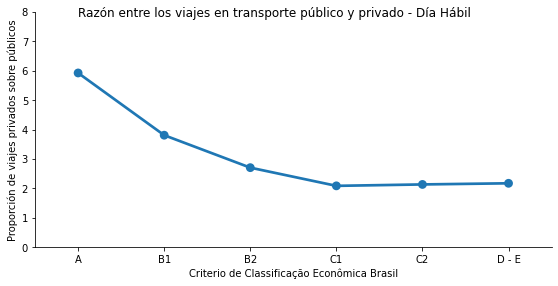

In [ ]:
g = sns.catplot(x="criteriobr", y="privado_sobre_publico", 
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Razón entre los viajes en transporte público y privado - Día Hábil')
g.set_ylabels('Proporción de viajes privados sobre públicos')
g.set_xlabels('Criterio de Classificação Econômica Brasil')
g.set(ylim=(0,8))

#fig.tight_layout()

Se observa una mayor razón de viajes en transporte privado sobre el público para los niveles socioeconómicos más altos, en especial para A y B, en contraste con los niveles socioeconómicos más bajos, donde los valores tienden a ser menores y similares entre sí.

#### **¿Cuál es la distribución/partición modal de los viajes por clasificador socioeconómico?**

Las siguientes tablas y gráficos representan la partición modal de los viajes realizados en días hábiles, por clasificador socioeconómico.

In [ ]:
print('Partición Modal de los Viajes - Día Hábil')
df = viajes_habiles.groupby(["criteriobr", 'modoprin']).sum()['fe_via'].unstack()
#.agg(count=('MEDIO_PREDOMINANTE','count')).unstack()
df.div(df.sum(axis=1), axis=0)

Partición Modal de los Viajes - Día Hábil


modoprin        A pé  ...  Ônibus/micro-ônibus/perua metropolitano
criteriobr            ...                                         
A           0.180341  ...                                 0.003511
B1          0.210927  ...                                 0.008909
B2          0.253763  ...                                 0.015283
C1          0.342137  ...                                 0.019246
C2          0.444680  ...                                 0.021764
D - E       0.502109  ...                                 0.019590

[6 rows x 17 columns]

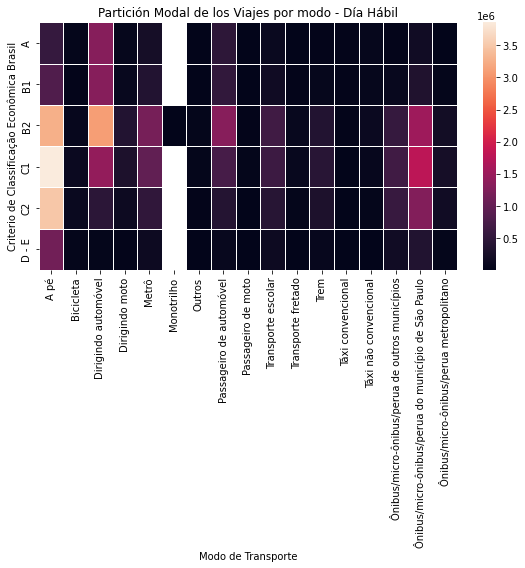

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

ax = sns.heatmap(df,linewidth=0.5)

ax.set_title("Partición Modal de los Viajes por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Criterio de Classificação Econômica Brasil")

fig.tight_layout()

En esta distribución, destaca la frecuencia del transporte a pie de las capas medias y bajas de esta clasificación, así como el uso de omnibus del municipio de Sao Paulo para las capas medias en particular. Para los niveles más altos, se observan los valores más altos tanto como conductores o pasajeros de automóviles.

In [ ]:
print('Partición Modal de los Viajes por tipo de transporte - Día Hábil')
df = viajes_habiles.groupby(["criteriobr", 'publico_privado']).sum()['fe_via'].unstack()
df_norm = df.div(df.sum(axis=1), axis=0)
df_norm

Partición Modal de los Viajes por tipo de transporte - Día Hábil


publico_privado      Otro   Privado   Público
criteriobr                                   
A                0.019889  0.838572  0.141539
B1               0.015804  0.779561  0.204635
B2               0.009408  0.723347  0.267245
C1               0.005858  0.672246  0.321896
C2               0.005699  0.677278  0.317024
D - E            0.004038  0.682278  0.313684

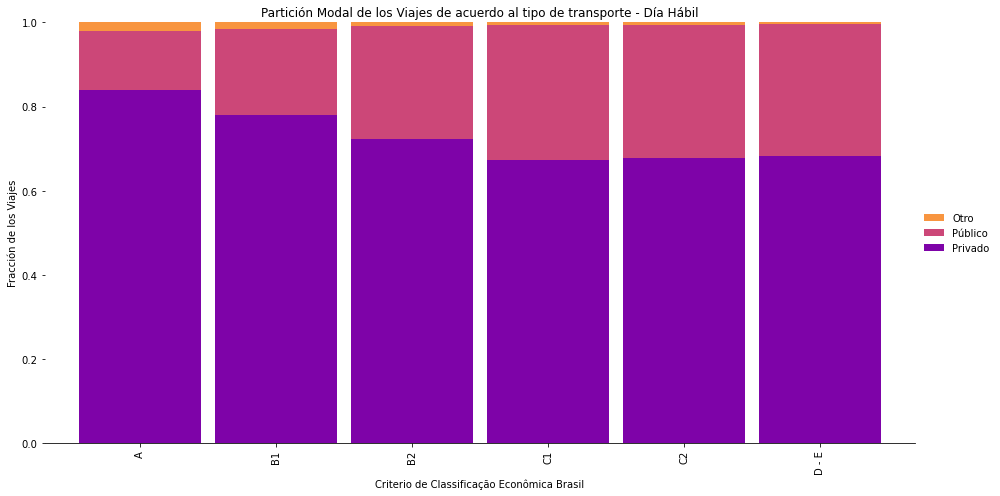

In [ ]:
from aves.visualization.tables import barchart

fig, ax = plt.subplots(figsize=(14, 7))

barchart(
    ax, df_norm, stacked=True, normalize=False, sort_categories=True, sort_items=False
)

ax.set_title("Partición Modal de los Viajes de acuerdo al tipo de transporte - Día Hábil")
ax.set_ylim([0, 1])
ax.set_xlabel("Criterio de Classificação Econômica Brasil")
ax.set_ylabel("Fracción de los Viajes")

fig.tight_layout()

En esta distribución, podemos ver que la fracción de viajes privados disminuye al bajar en los niveles socioeconómicos, donde se llega a un valor similar entre los 3 últimos niveles. 

### Parte II: Indicadores de Tiempo de Viajes

En esta segunda parte, responderemos algunas preguntas respecto a indicadores de tiempo de viajes realizados, en días hábiles de viaje. Para esto, buscaremos responder las siguientes preguntas:
1. ¿Cuál es el tiempo promedio de viaje por modo y tipo de transporte?
2. ¿Cuál es el tiempo promedio de viaje en hora punta de mañana?
3. ¿Cuál es el tiempo de viaje en transporte público en hora punta de mañana?
4. ¿Cuál es el tiempo promedio de viaje al trabajo en transporte público?

In [ ]:
viajes_habiles['duracion_minutos'] = viajes_habiles['duracao'].astype('int64')
#viajes_nohabiles['duracion_minutos'] = pd.to_timedelta(viajes_nohabiles['duracao'])/pd.Timedelta('60s')

#### **¿Cuál es el tiempo promedio de viaje por modo y tipo de transporte?**

A continuación, se representa el promedio y mediana en minutos de viaje por modo y tipo de transporte, en días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Duración promedio (en minutos) de viaje por modo - Dia Hábil')
df = viajes_habiles.groupby(["criteriobr", "modoprin"]).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'fe_via')).unstack()

Duración promedio (en minutos) de viaje por modo - Dia Hábil


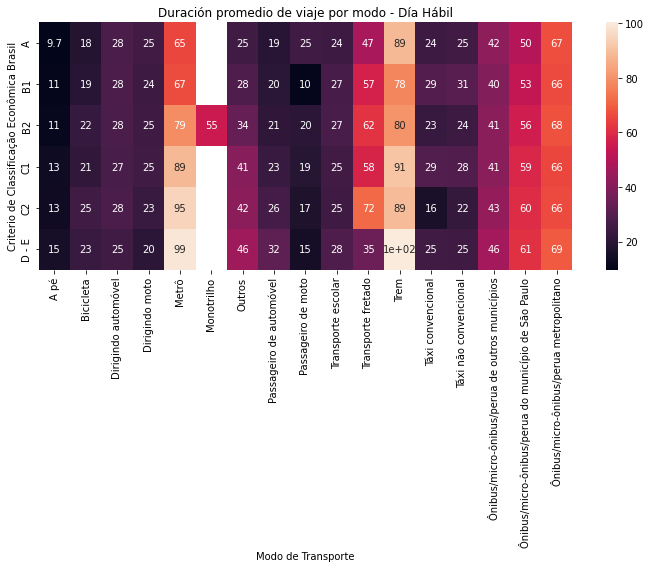

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Criterio de Classificação Econômica Brasil")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por modo - Dia Hábil')
df = viajes_habiles.groupby(["criteriobr", "modoprin"]).apply(lambda x: weighted_median(x, 'duracion_minutos', 'fe_via')).unstack()
df

Duración mediana (en minutos) de viaje por modo - Dia Hábil


modoprin    A pé  ...  Ônibus/micro-ônibus/perua metropolitano
criteriobr        ...                                         
A            7.0  ...                                     60.0
B1          10.0  ...                                     60.0
B2          10.0  ...                                     60.0
C1          10.0  ...                                     60.0
C2          10.0  ...                                     60.0
D - E       10.0  ...                                     60.0

[6 rows x 17 columns]

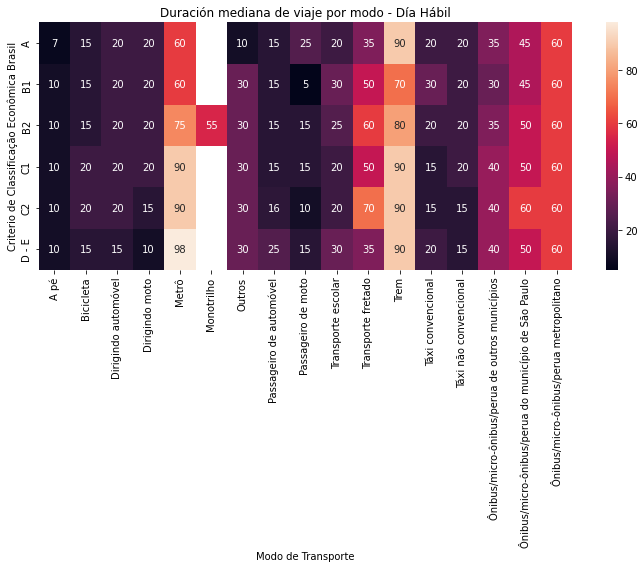

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Criterio de Classificação Econômica Brasil")

fig.tight_layout()

Ambas medidas de tendencia central muestran que los modos de transporte con duraciones más largas son metro, tren y omnibus, con los tiempos promedios de viaje aumentando a medida que se baja de nivel socioeconómico para algunos de los modos.

In [ ]:
print('Duración promedio (en minutos) de viaje por tipo de transporte - Dia Hábil')
df = viajes_habiles.groupby(["criteriobr", 'publico_privado']).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'fe_via')).unstack()
df

Duración promedio (en minutos) de viaje por tipo de transporte - Dia Hábil


publico_privado       Otro    Privado    Público
criteriobr                                      
A                25.347244  22.628288  57.851461
B1               30.855438  22.602749  58.556579
B2               24.036605  23.104515  61.940182
C1               28.469432  23.186793  63.831976
C2               22.057604  21.560657  63.683832
D - E            24.634914  21.785910  64.910443

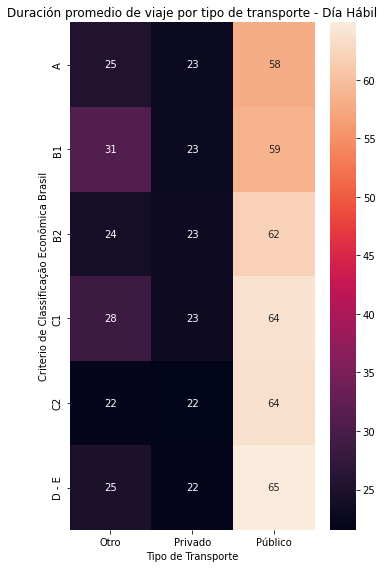

In [ ]:
fig, ax = plt.subplots(figsize=(5, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por tipo de transporte - Día Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Criterio de Classificação Econômica Brasil")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por tipo de transporte - Dia Hábil')
df = viajes_habiles.groupby(["criteriobr", 'publico_privado']).apply(lambda x: weighted_median(x, 'duracion_minutos', 'fe_via')).unstack()
df

Duración mediana (en minutos) de viaje por tipo de transporte - Dia Hábil


publico_privado  Otro  Privado  Público
criteriobr                             
A                  20       15       50
B1                 20       15       50
B2                 20       15       60
C1                 20       15       60
C2                 15       15       60
D - E              15       15       60

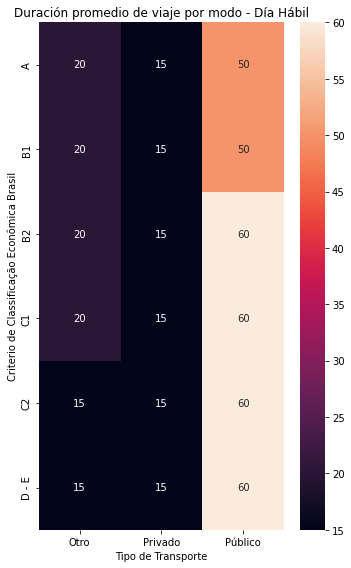

In [ ]:
fig, ax = plt.subplots(figsize=(5, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por modo - Día Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Criterio de Classificação Econômica Brasil")

fig.tight_layout()

Para los tipos de transporte, las medidas de tendencia central nos muestran una gran diferencia de duración entre transporte público y privado, donde el transporte público tiene viajes de mayor duración, los cuales también aumentan al bajar de nivel socioeconómico.

#### **¿Cuál es el tiempo promedio de viaje en hora punta de mañana?**

Los siguientes tablas y gráficos representan el tiempo promedio de viaje a hora punta por la mañana por modo y tipo de transporte, y por clasificador socioeconómico.

In [ ]:
print('Duración promedio (en minutos) de viaje por modo en hora punta - Dia Hábil')
df = viajes_habiles[viajes_habiles.PICO_HABIL=='Si'].groupby(["criteriobr", 'modoprin']).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'fe_via')).unstack()
df 

Duración promedio (en minutos) de viaje por modo en hora punta - Dia Hábil


modoprin         A pé  ...  Ônibus/micro-ônibus/perua metropolitano
criteriobr             ...                                         
A           11.852555  ...                                82.412385
B1          11.638907  ...                                50.924950
B2          10.706071  ...                                59.707650
C1          13.016271  ...                                59.763615
C2          13.772462  ...                                60.228100
D - E       15.952420  ...                                61.674930

[6 rows x 16 columns]

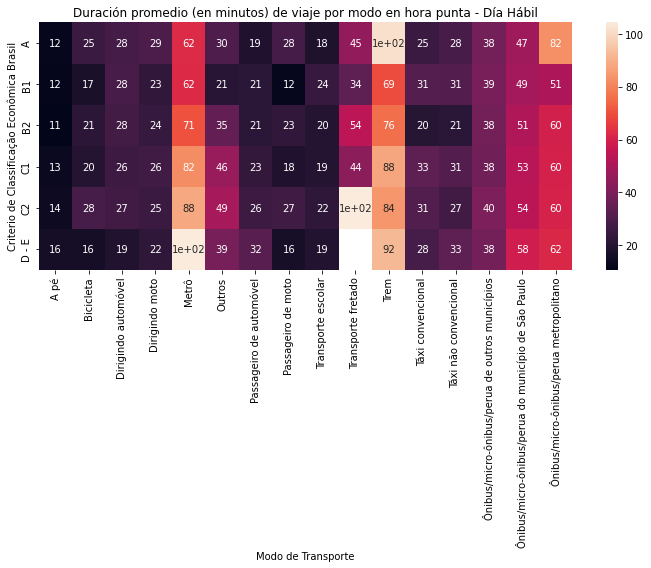

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio (en minutos) de viaje por modo en hora punta - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Criterio de Classificação Econômica Brasil")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por modo en hora punta - Dia Hábil')
df = viajes_habiles[viajes_habiles.PICO_HABIL=='Si'].groupby(["criteriobr", 'modoprin']).apply(lambda x: weighted_median(x, 'duracion_minutos', 'fe_via')).unstack()
df

Duración mediana (en minutos) de viaje por modo en hora punta - Dia Hábil


modoprin    A pé  ...  Ônibus/micro-ônibus/perua metropolitano
criteriobr        ...                                         
A           10.0  ...                                     90.0
B1          10.0  ...                                     50.0
B2          10.0  ...                                     50.0
C1          10.0  ...                                     60.0
C2          10.0  ...                                     60.0
D - E       10.0  ...                                     60.0

[6 rows x 16 columns]

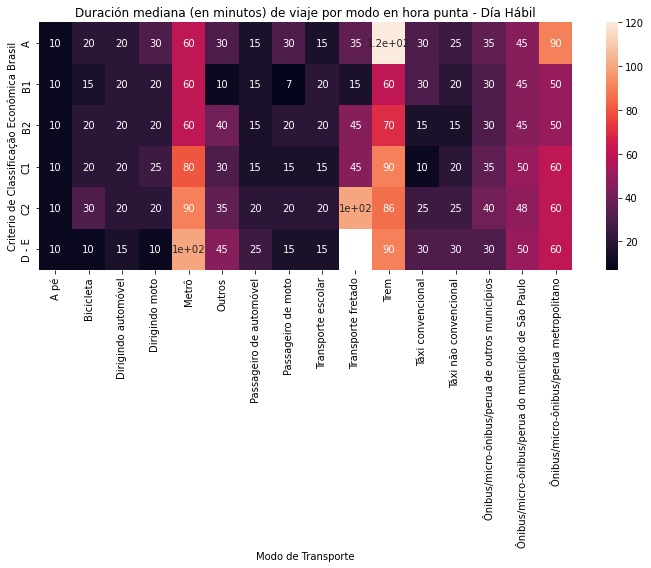

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana (en minutos) de viaje por modo en hora punta - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Criterio de Classificação Econômica Brasil")

fig.tight_layout()

Las medidas de tendencia central muestran resultados de duración de viaje similares a los vistos en la pregunta anterior, sin diferencia para la hora punta de mañana, con el metro, tren y omnibus como los modos con mayores tiempos de duración de viaje, y con tendencia al aumento a medida que se baja de nivel socioeconómico.

In [ ]:
print('Duración promedio (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil')
df = viajes_habiles[(viajes_habiles.PICO_HABIL=='Si')].groupby(["criteriobr",'publico_privado']).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'fe_via')).unstack()
df

Duración promedio (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil


publico_privado       Otro    Privado    Público
criteriobr                                      
A                28.469361  24.232377  55.784887
B1               31.149200  23.860144  54.457448
B2               21.006691  22.812038  56.413930
C1               31.002107  22.305466  58.035292
C2               26.969480  21.542564  56.226518
D - E            33.416520  22.094777  60.444729

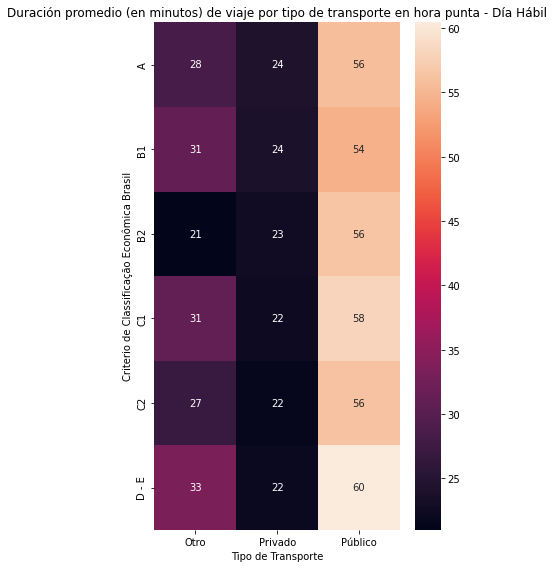

In [ ]:
fig, ax = plt.subplots(figsize=(5, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio (en minutos) de viaje por tipo de transporte en hora punta - Día Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Criterio de Classificação Econômica Brasil")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil')
df = viajes_habiles[(viajes_habiles.PICO_HABIL=='Si')].groupby(["criteriobr", 'publico_privado']).apply(lambda x: weighted_median(x, 'duracion_minutos', 'fe_via')).unstack()
df

Duración mediana (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil


publico_privado  Otro  Privado  Público
criteriobr                             
A                  25       20       50
B1                 20       15       50
B2                 15       15       50
C1                 20       15       50
C2                 25       15       50
D - E              30       15       50

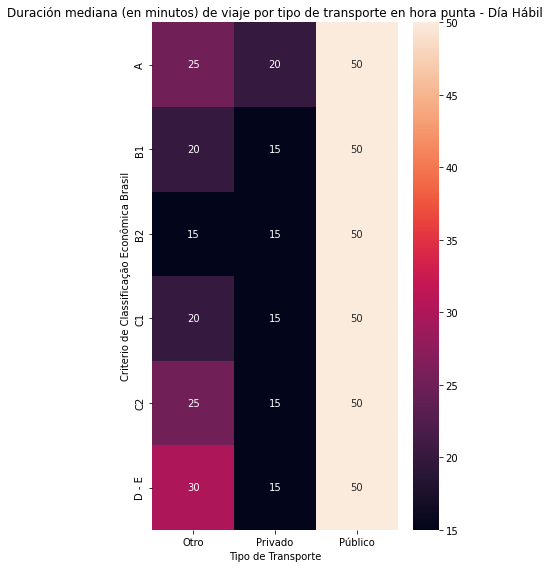

In [ ]:
fig, ax = plt.subplots(figsize=(5, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana (en minutos) de viaje por tipo de transporte en hora punta - Día Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Criterio de Classificação Econômica Brasil")

fig.tight_layout()

Las tendencias de medida central de duración por tipo muestran valores similares a la pregunta anterior, sin diferencia para el horario de hora punta de mañana, y con una gran diferencia de duración de viaje entre el transporte privado y público, pero sin diferencia a través de los niveles socioeconómicos.

#### **¿Cuál es el tiempo de viaje en transporte público en hora punta de mañana?**

A continuación, se presentan los resultados para duración promedio de viaje en hora punta de mañana en transporte público, en día hábil, por clasificador socioeconómico.

In [ ]:
print('Duración promedio (en minutos) de viaje hora punta en transporte público - Dia Hábil')
mask = (viajes_habiles.publico_privado=='Público')
df = viajes_habiles[viajes_habiles.PICO_HABIL=='Si'][mask].groupby(["criteriobr", 'modoprin']).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'fe_via')).unstack()
df 

Duración promedio (en minutos) de viaje hora punta en transporte público - Dia Hábil


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


modoprin         Metrô  ...  Ônibus/micro-ônibus/perua metropolitano
criteriobr              ...                                         
A            62.345786  ...                                82.412385
B1           62.182977  ...                                50.924950
B2           70.659951  ...                                59.707650
C1           82.296927  ...                                59.763615
C2           87.885233  ...                                60.228100
D - E       104.155518  ...                                61.674930

[6 rows x 4 columns]

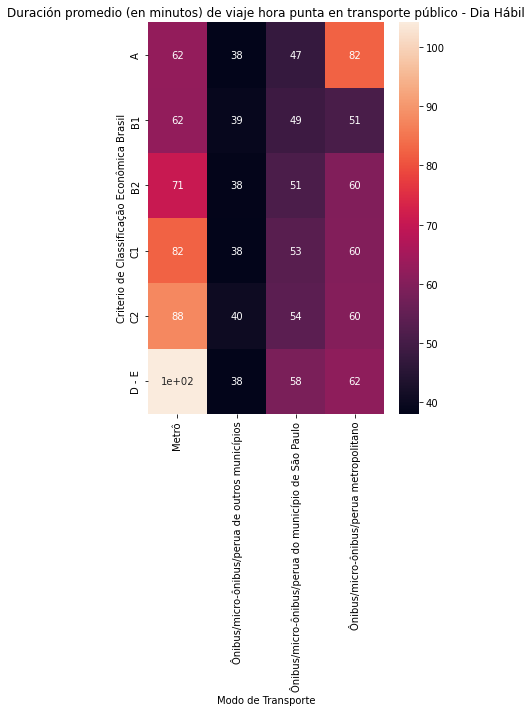

In [ ]:
fig, ax = plt.subplots(figsize=(5, 10))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio (en minutos) de viaje hora punta en transporte público - Dia Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Criterio de Classificação Econômica Brasil")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje hora punta en transporte público - Dia Hábil')
mask = (viajes_habiles.publico_privado=='Público')
df = viajes_habiles[viajes_habiles.PICO_HABIL=='Si'][mask].groupby(["criteriobr", 'modoprin']).apply(lambda x: weighted_median(x, 'duracion_minutos', 'fe_via')).unstack()
df 

Duración mediana (en minutos) de viaje hora punta en transporte público - Dia Hábil


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


modoprin    Metrô  ...  Ônibus/micro-ônibus/perua metropolitano
criteriobr         ...                                         
A              60  ...                                       90
B1             60  ...                                       50
B2             60  ...                                       50
C1             80  ...                                       60
C2             90  ...                                       60
D - E         100  ...                                       60

[6 rows x 4 columns]

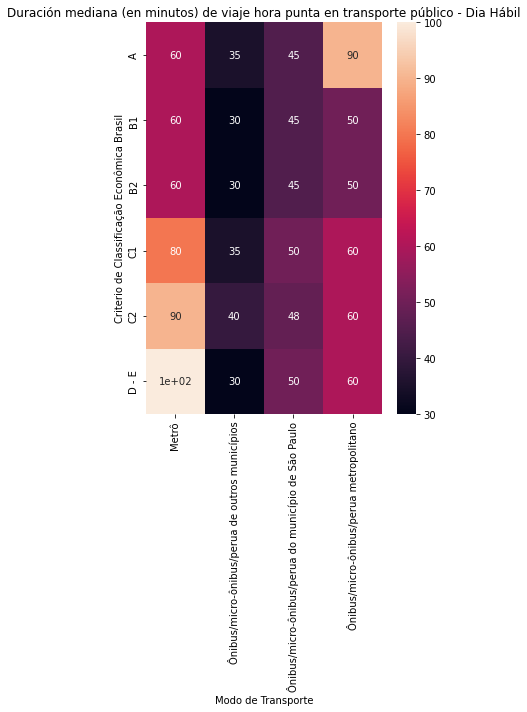

In [ ]:
fig, ax = plt.subplots(figsize=(5, 10))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana (en minutos) de viaje hora punta en transporte público - Dia Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Criterio de Classificação Econômica Brasil")

fig.tight_layout()

Las medidas de tendencia central muestran una mayor duración de viajes durante el horario de hora punta de mañana para el metro en particular, y para el omnibus metropolitano en una menor medida. Se observa un aumento de la duración a medida que se baja en nivel socioeconómico, excepto para le modo de onmnibus metropolitano, donde los viajes de mayor duración corresponden al nivel más alto.

#### **¿Cuál es el tiempo promedio de viaje al trabajo en transporte público?**

A continuación, se presentan los resultados de tiempo promedio de viaje al trabajo en transporte público, por clasificador socioeconómico.

In [ ]:
work = ['Trabalho Serviços','Trabalho Comércio', 'Procurar Emprego', 'Trabalho Indústria']

In [ ]:
print('Duración promedio (en minutos) de viaje al trabajo en transporte público - Dia Hábil')
mask = (viajes_habiles.publico_privado=='Público') & (viajes_habiles.motivo_d.isin(work))
df = viajes_habiles[mask].groupby(["criteriobr", "modoprin"]).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'fe_via')).unstack()
df

Duración promedio (en minutos) de viaje al trabajo en transporte público - Dia Hábil


modoprin         Metrô  ...  Ônibus/micro-ônibus/perua metropolitano
criteriobr              ...                                         
A            64.565766  ...                                80.079943
B1           66.382716  ...                                65.829035
B2           80.318190  ...                                67.609109
C1           91.125049  ...                                67.674489
C2           93.427503  ...                                66.559067
D - E       102.653830  ...                                71.254626

[6 rows x 4 columns]

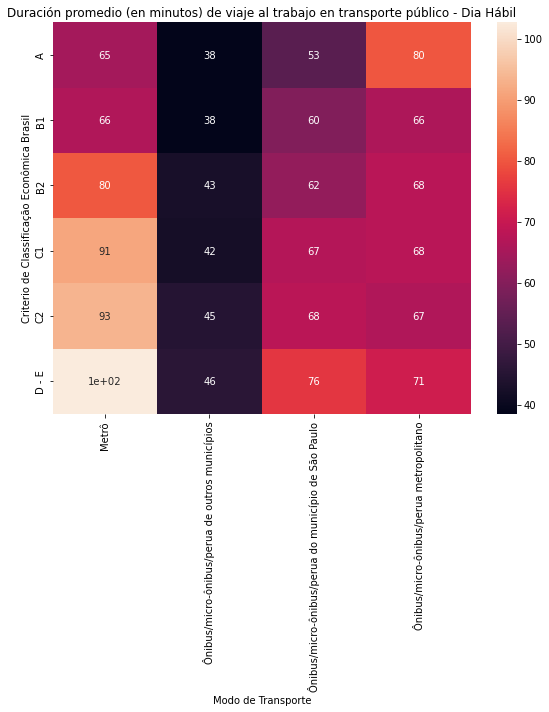

In [ ]:
fig, ax = plt.subplots(figsize=(8, 10))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio (en minutos) de viaje al trabajo en transporte público - Dia Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Criterio de Classificação Econômica Brasil")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje al trabajo en transporte público - Dia Hábil')
mask = (viajes_habiles.publico_privado=='Público') & (viajes_habiles.motivo_d.isin(work))
df = viajes_habiles[mask].groupby(["criteriobr", "modoprin"]).apply(lambda x: weighted_median(x, 'duracion_minutos', 'fe_via')).unstack()
df

Duración mediana (en minutos) de viaje al trabajo en transporte público - Dia Hábil


modoprin    Metrô  ...  Ônibus/micro-ônibus/perua metropolitano
criteriobr         ...                                         
A              60  ...                                       90
B1             60  ...                                       60
B2             75  ...                                       60
C1             90  ...                                       60
C2             90  ...                                       60
D - E         100  ...                                       60

[6 rows x 4 columns]

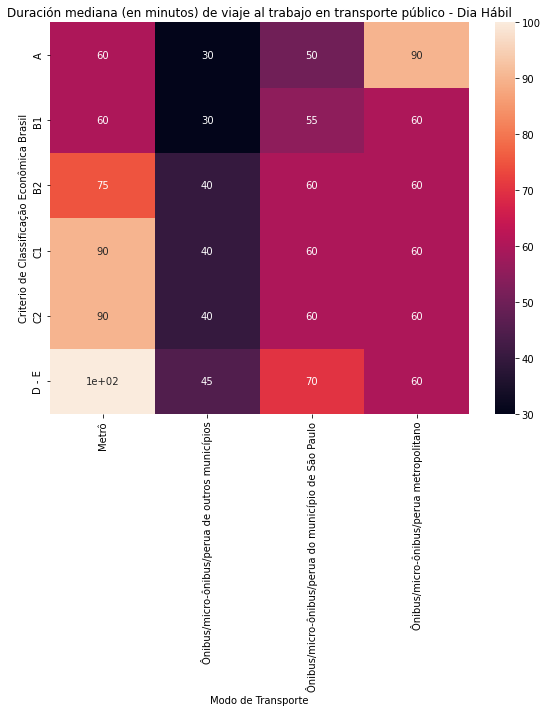

In [ ]:
fig, ax = plt.subplots(figsize=(8, 10))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana (en minutos) de viaje al trabajo en transporte público - Dia Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Criterio de Classificação Econômica Brasil")

fig.tight_layout()

Se observan los valores más altos de duración de viaje al trabajo para el metro, y con una tendencia al aumento de duración de viaje a medida que se baja en nivel socioeconómico, excepto para el omnibus metropolitano, donde el valor más alto corresponde al nivel más alto.

### Parte III: Indicadores de Distancia de Viajes
1. Distancia de viajes en auto (histograma de viajes por km)
2.Distancia de viajes en transporte público (histograma de viajes por km)
3.Distancia de viajes por motivo estudio (histograma de viajes por km)
4.Distancia de viajes por motivo al trabajo (histograma de viajes por km)
5.Viajes interzonales como intrazonales


En esta sección, se presentarán los indicadores de distancia de viajes durante días hábiles.

#### **Distancia de viajes en auto (histograma de viajes por km)**

In [ ]:
car = ['Dirigindo automóvel', 'Passageiro de automóvel']

Distancia de viajes en auto - Día Hábil


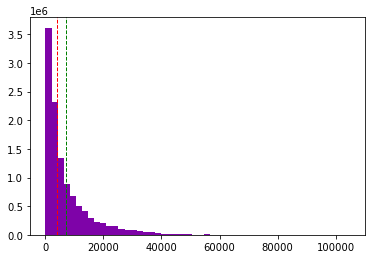

In [ ]:
from matplotlib.pyplot import hist
print('Distancia de viajes en auto - Día Hábil')
mask = (viajes_habiles.modoprin.isin(car))
df = viajes_habiles[mask].groupby('distancia_manhattan').sum()[['fe_via']].reset_index().sort_values('distancia_manhattan')
hist(df.distancia_manhattan, weights=df.fe_via, bins=50)
plt.axvline(viajes_habiles[mask].groupby('id_ordem').apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'fe_via')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_habiles[mask].groupby('id_ordem').apply(lambda x: weighted_median(x, 'distancia_manhattan', 'fe_via')).median(), color='red', linestyle='dashed', linewidth=1)
#Verde Promedio
#Rojo Mediana

#### **Distancia de viajes en transporte público**

Distancia de viajes en transporte público - Día Hábil


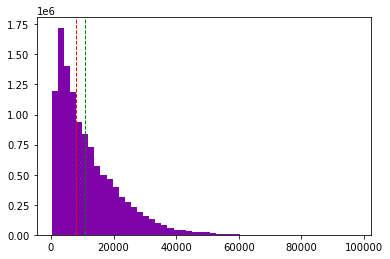

In [ ]:
print('Distancia de viajes en transporte público - Día Hábil')
mask = (viajes_habiles.publico_privado == 'Público')
df = viajes_habiles[mask].groupby('distancia_manhattan').sum()[['fe_via']].reset_index().sort_values('distancia_manhattan')
hist(df.distancia_manhattan, weights=df.fe_via, bins=50)
plt.axvline(viajes_habiles[mask].groupby('id_ordem').apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'fe_via')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_habiles[mask].groupby('id_ordem').apply(lambda x: weighted_median(x, 'distancia_manhattan', 'fe_via')).median(), color='red', linestyle='dashed', linewidth=1)
#Verde Promedio
#Rojo Mediana

#### **Distancia de viajes por motivo estudio**

Distancia de viajes con motivo de estudio


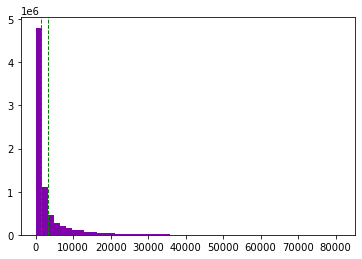

In [ ]:
print('Distancia de viajes con motivo de estudio')
mask = (viajes_personas.motivo_d == 'Escola/Educação')
df = viajes_personas[mask].groupby('distancia_manhattan').sum()[['fe_via']].reset_index().sort_values('distancia_manhattan')
hist(df.distancia_manhattan, weights=df.fe_via, bins=50)
plt.axvline(viajes_habiles[mask].groupby('id_ordem').apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'fe_via')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_habiles[mask].groupby('id_ordem').apply(lambda x: weighted_median(x, 'distancia_manhattan', 'fe_via')).median(), color='red', linestyle='dashed', linewidth=1)
#Verde Promedio
#Rojo Mediana

#### **Distancia de viajes por motivo trabajo**

Distancia de viajes con motivo de trabajo


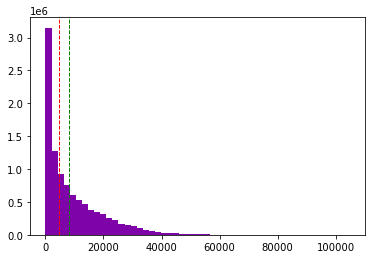

In [ ]:
print('Distancia de viajes con motivo de trabajo')
mask = (viajes_personas.motivo_d.isin(work))
df = viajes_personas[mask].groupby('distancia_manhattan').sum()[['fe_via']].reset_index().sort_values('distancia_manhattan')
hist(df.distancia_manhattan, weights=df.fe_via, bins=50)
plt.axvline(viajes_habiles[mask].groupby('id_ordem').apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'fe_via')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_habiles[mask].groupby('id_ordem').apply(lambda x: weighted_median(x, 'distancia_manhattan', 'fe_via')).median(), color='red', linestyle='dashed', linewidth=1)
#Verde Promedio
#Rojo Mediana

#### **Viajes intra vs interzonales**

In [ ]:
print('% de viajes Inter e Intra zonales')
df = viajes_personas.groupby(['motivo_d','sexo','Intra_Inter']).sum()['fe_via'].unstack()
df.div(df.sum(axis=1), axis=0)

% de viajes Inter e Intra zonales


Intra_Inter                           Inter     Intra
motivo_d                sexo                         
Assuntos Pessoais       Feminino   0.735440  0.264560
                        Masculino  0.740134  0.259866
Compras                 Feminino   0.674997  0.325003
                        Masculino  0.668493  0.331507
Escola/Educação         Feminino   0.445420  0.554580
                        Masculino  0.474582  0.525418
Médico/Dentista/Saúde   Feminino   0.798405  0.201595
                        Masculino  0.843679  0.156321
Procurar Emprego        Feminino   0.927468  0.072532
                        Masculino  0.917939  0.082061
Recreação/Visitas/Lazer Feminino   0.723584  0.276416
                        Masculino  0.716562  0.283438
Refeição                Feminino   0.331529  0.668471
                        Masculino  0.309447  0.690553
Residência              Feminino   0.624045  0.375955
                        Masculino  0.661264  0.338736
Trabalho Comércio       Feminino   0.679211  0.320789
                        Masculino  0.708075  0.291925
Trabalho Indústria      Feminino   0.729526  0.270474
                        Masculino  0.724216  0.275784
Trabalho Serviços       Feminino   0.762152  0.237848
                        Masculino  0.766731  0.233269

### ¿Dónde se concentran las personas que utilizan cada modo de transporte en la ciudad para distintos propósitos?

<AxesSubplot:>

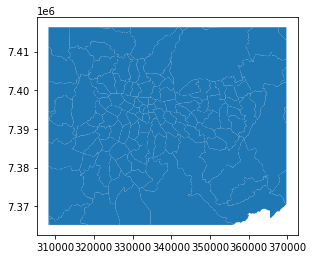

In [ ]:
from aves.features.geo import clip_area_geodataframe
bbox = [308288.7305,7365205.3028,369753.2266,7416271.5609]

zonas_en_caja = clip_area_geodataframe(city_shp.to_crs('epsg:22523'), bbox)
zonas_en_caja.plot()

In [ ]:
bounds = zonas_en_caja.to_crs('EPSG:4686').total_bounds

In [ ]:
import contextily as cx

scl_img, scl_ext = cx.bounds2raster(bounds[0], bounds[1], bounds[2], bounds[3], 
    "saopaulo_toner_12.tif",
    ll=True,
    source=cx.providers.Stamen.TonerBackground,
    zoom=12,
)

In [ ]:
def transform_motives(row):
  if row['motivo_d'] in ['Trabalho Serviços', 'Trabalho Comércio', 'Trabalho Indústria']:
    return 'Trabajo'
  elif row['motivo_d']=='Escola/Educação':
    return 'Estudios'
  else:
    return row['motivo_d']

In [ ]:
def transform_omnibus(row):
  if row['modoprin'] in ['Ônibus/micro-ônibus/perua do município de São Paulo', 'Ônibus/micro-ônibus/perua metropolitano', 'Ônibus/micro-ônibus/perua de outros municípios']:
    return 'Ônibus/micro-ônibus/perua'
  else:
    return row['modoprin']

In [ ]:
viajes_personas['proposito'] = viajes_personas.apply(lambda x: transform_motives(x), axis=1)

In [ ]:
viajes_personas['modoprin_fix'] = viajes_personas.apply(lambda x: transform_omnibus(x), axis=1)

In [ ]:
from aves.features.geo import to_point_geodataframe
origenes_viajes = to_point_geodataframe(viajes_personas, 'co_o_x' , 'co_o_y', crs='epsg:22523')
destinos_viajes = to_point_geodataframe(viajes_personas, 'co_d_x', 'co_d_y', crs='epsg:22523')

In [ ]:
from aves.features.geo import clip_point_geodataframe

origenes_viajes = origenes_viajes[(origenes_viajes['id_ordem'].isin(destinos_viajes['id_ordem']))]
origenes_viajes = clip_point_geodataframe(origenes_viajes, zonas_en_caja.total_bounds)
destinos_viajes = destinos_viajes[(destinos_viajes['id_ordem'].isin(origenes_viajes['id_ordem']))]
destinos_viajes = clip_point_geodataframe(destinos_viajes, zonas_en_caja.total_bounds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


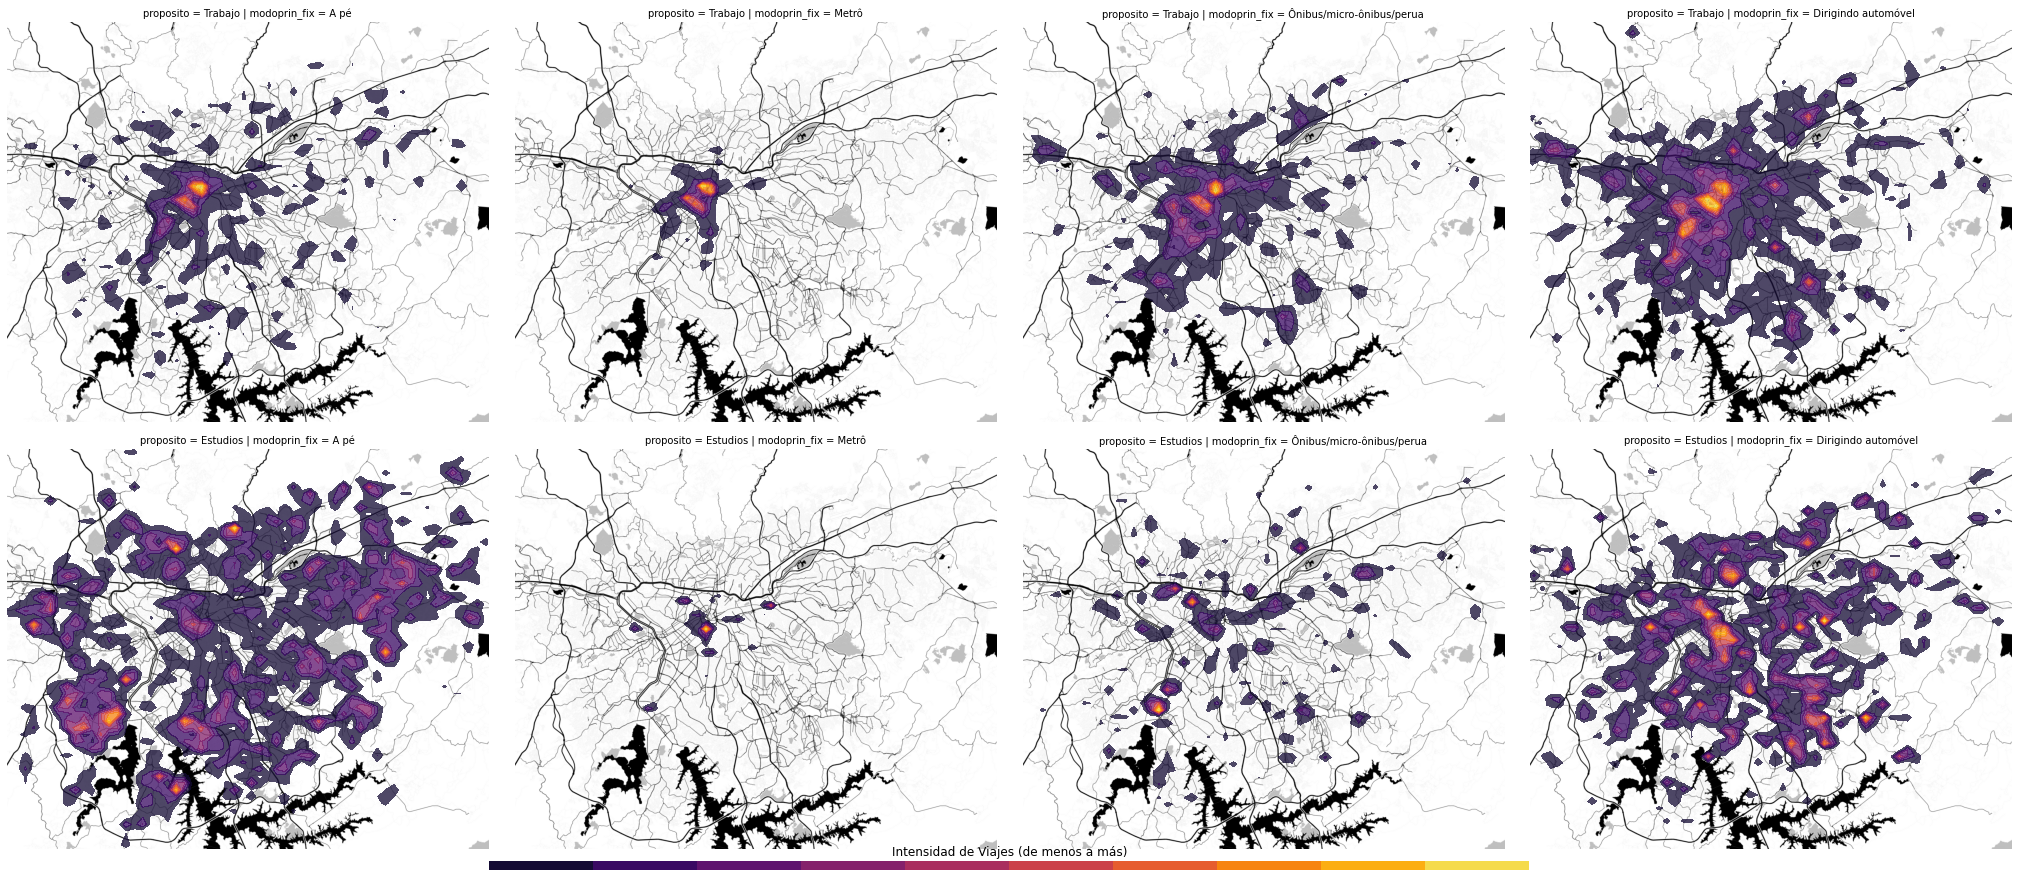

In [ ]:
from aves.visualization.figures import GeoFacetGrid

from aves.visualization.maps import heat_map

grid = GeoFacetGrid(
    origenes_viajes,
    context=zonas_en_caja,
    row="proposito",
    col="modoprin_fix",
    row_order=["Trabajo", "Estudios"],
    col_order=['A pé', 'Metrô', 'Ônibus/micro-ônibus/perua', 'Dirigindo automóvel'],
    height=6,
    hue="modoprin_fix"
)
grid.add_basemap("saopaulo_toner_12.tif")
#grid.add_layer(city_shp_filt, color="#efefef", edgecolor="white", linewidth=1)

grid.add_layer(
    heat_map,
    # atributo de los datos con la importancia o peso de cada viaje
    weight="fe_via",
    # cantidad de niveles/colores del mapa de calor
    n_levels=10,
    # radio de influencia de cada viaje
    bandwidth=0.05,
    # valor de corte para los valores bajos del heatmap
    low_threshold=0.075,
    # transparencia
    alpha=0.75,
    # paleta de colores
    palette="inferno"
)

grid.add_global_colorbar('inferno', 10, title='Intensidad de Viajes (de menos a más)', orientation='horizontal')
#grid.set_title("Viajes a trabajar y a estudiar de acuerdo al modo de transporte")
grid.fig.tight_layout()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


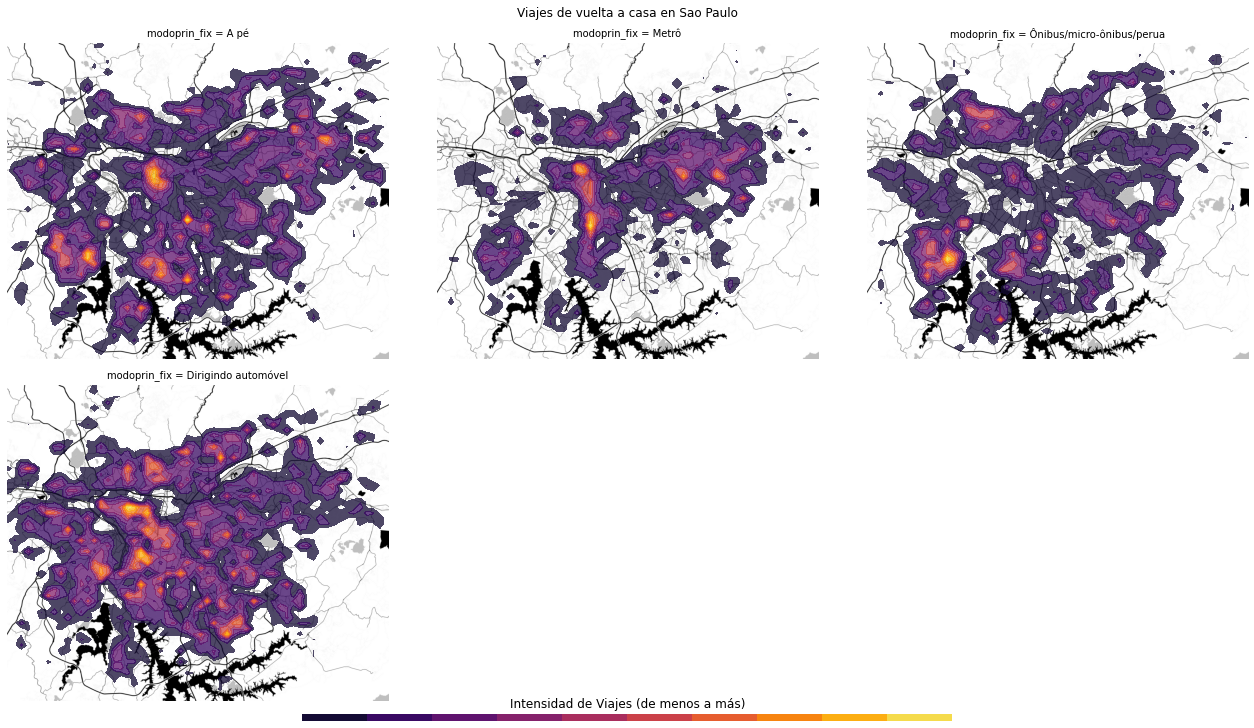

In [ ]:
grid = GeoFacetGrid(
    destinos_viajes[destinos_viajes.proposito=='Residência'],
    context=zonas_en_caja,
    #row="MOTIVOVIAJE",
    col="modoprin_fix",
    col_wrap=3,
    row_order=["Residência"],
    col_order=['A pé', 'Metrô', 'Ônibus/micro-ônibus/perua', 'Dirigindo automóvel'],
    height=5,
    hue="modoprin_fix"
)
grid.add_basemap("saopaulo_toner_12.tif")
#grid.add_layer(city_shp_filt, color="#efefef", edgecolor="white", linewidth=1, alpha=0.5)

grid.add_layer(
    heat_map,
    # atributo de los datos con la importancia o peso de cada viaje
    weight="fe_via",
    # cantidad de niveles/colores del mapa de calor
    n_levels=10,
    # radio de influencia de cada viaje
    bandwidth=0.005,
    # valor de corte para los valores bajos del heatmap
    low_threshold=0.075,
    # transparencia
    alpha=0.75,
    # paleta de colores
    palette="inferno"
)
grid.add_global_colorbar('inferno', 10, title='Intensidad de Viajes (de menos a más)', orientation='horizontal')
grid.set_title("Viajes de vuelta a casa en Sao Paulo")
grid.fig.tight_layout()

#### ¿Cuán lejos queda el trabajo de acuerdo al lugar de residencia?

Con esta pregunta queremos entender si existe un patrón geográfico en las elecciones de residencia y trabajo de las personas.

Para responder la pregunta, primero filtramos los viajes que nos interesan:

In [ ]:
viajes_trabajo

id_pess  ...                        geometry
0       00010001101  ...  POINT (333104.000 7394476.000)
2       00010001102  ...  POINT (327503.000 7392159.000)
5       00010002101  ...  POINT (333453.000 7394501.000)
9       00010002102  ...  POINT (333539.000 7394387.000)
13      00010002103  ...  POINT (332344.000 7393317.000)
...             ...  ...                             ...
157937  05170433107  ...  POINT (310512.000 7397336.000)
157939  05170452101  ...  POINT (308664.000 7398596.000)
157942  05170452102  ...  POINT (308664.000 7398596.000)
157960  05171174102  ...  POINT (310126.000 7400431.000)
157973  05171409102  ...  POINT (327864.000 7391634.000)

[30323 rows x 31 columns]

In [ ]:
viajes_todos = origenes_viajes[(pd.notnull(origenes_viajes.fe_via)) &
                                (origenes_viajes.distancia_manhattan > 0)].drop_duplicates(subset=['id_pess'], keep='first')

In [ ]:
viajes_trabajo = origenes_viajes[(origenes_viajes.proposito == 'Trabajo') &
                                (pd.notnull(origenes_viajes.fe_via)) &
                                (origenes_viajes.distancia_manhattan > 0)].drop_duplicates(subset=['id_pess'], keep='first')
                                
print(len(viajes_trabajo), viajes_trabajo.fe_via.sum())

30323 7890448.072536568


In [ ]:
distancia_zonas_mean = (viajes_trabajo
                   .groupby(['zona_o'])
                   .apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'fe_via'))
                   .rename('media_distancia_al_trabajo')
)

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


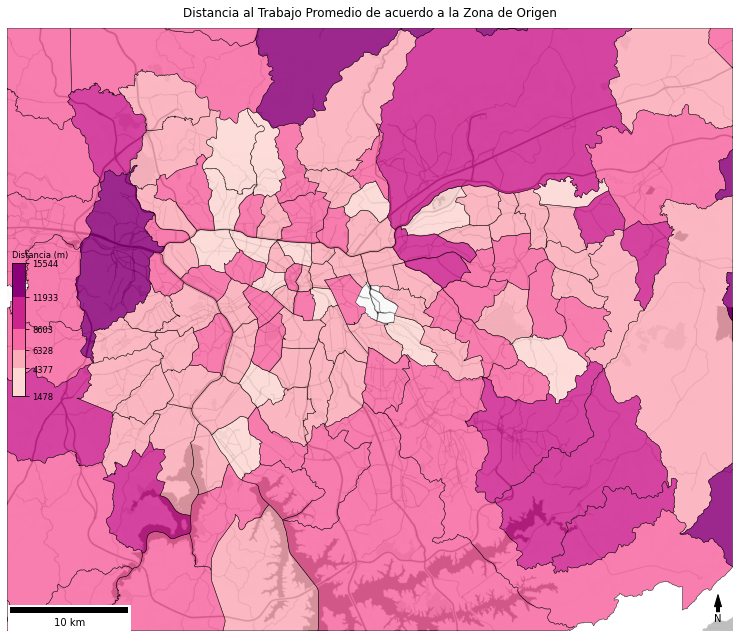

In [ ]:
from aves.visualization.maps import choropleth_map
grid = GeoFacetGrid(zonas_en_caja.join(distancia_zonas_mean, how="left"), height=9)
grid.add_basemap("saopaulo_toner_12.tif")
grid.add_layer(
    choropleth_map,
    "media_distancia_al_trabajo",
    k=5,
    linewidth=0.5,
    edgecolor="black",
    binning="fisher_jenks",
    palette="RdPu",
    alpha=0.85,
    cbar_args=dict(
        label="Distancia (m)",
        height="22%",
        width="2%",
        orientation="vertical",
        location="center left",
        label_size="small",
        bbox_to_anchor=(0.0, 0.0, 0.9, 1.0),
    ),
)
grid.add_map_elements()
grid.set_title("Distancia al Trabajo Promedio de acuerdo a la Zona de Origen")
grid.tight_layout()

In [ ]:
zonas_en_caja.columns

Index(['NumeroDist', 'NomeDistri', 'Area_ha', 'geometry', 'x_coord',
       'y_coord'],
      dtype='object')

In [ ]:
matriz_zonas = (viajes_trabajo[(viajes_trabajo['zona_o'] != viajes_trabajo['zona_d'])
                            
                             & (viajes_trabajo['zona_o'].isin(zonas_en_caja.NumeroDist))
                             & (viajes_trabajo['zona_d'].isin(zonas_en_caja.NumeroDist))]
                    .groupby(['zona_o', 'zona_d'])
                    .agg(n_viajes=('fe_via', 'sum'))
                    .sort_values('n_viajes', ascending=False)
                    .assign(cumsum_viajes=lambda x: x['n_viajes'].cumsum())
                    .assign(cumsum_viajes=lambda x: x['cumsum_viajes'] / x['cumsum_viajes'].max())
                    .reset_index()
)
matriz_zonas.to_csv(data_path + '/matriz_zonas_trabajo_saopaulo2017.csv', index=False)

In [ ]:
matriz_zonas = (viajes_todos[(viajes_todos['zona_o'] != viajes_todos['zona_d'])
                            
                             & (viajes_todos['zona_o'].isin(zonas_en_caja.NumeroDist))
                             & (viajes_todos['zona_d'].isin(zonas_en_caja.NumeroDist))]
                    .groupby(['zona_o', 'zona_d'])
                    .agg(n_viajes=('fe_via', 'sum'))
                    .sort_values('n_viajes', ascending=False)
                    .assign(cumsum_viajes=lambda x: x['n_viajes'].cumsum())
                    .assign(cumsum_viajes=lambda x: x['cumsum_viajes'] / x['cumsum_viajes'].max())
                    .reset_index()
)
matriz_zonas.to_csv(data_path + '/matriz_zonas_todos_saopaulo2017.csv', index=False)

In [ ]:
matriz_zonas = matriz_zonas[matriz_zonas['cumsum_viajes'] <= 0.8]

In [ ]:
merged_zones = zonas_en_caja.dissolve('NumeroDist')#.drop('id', axis=1)

In [ ]:
from aves.models.network import Network
from aves.visualization.networks import NodeLink

zone_od_network = Network.from_edgelist(
    matriz_zonas, source="zona_o", target="zona_d", weight="n_viajes"
)

In [ ]:
zone_nodelink = NodeLink(zone_od_network)
zone_nodelink.layout_nodes(method="geographical", geodataframe=merged_zones)
zone_nodelink.set_node_drawing("plain", weights=zone_od_network.node_degree("in"))
zone_nodelink.set_edge_drawing(method="origin-destination")

In [ ]:
def plot_network(ax, geo_data, *args, **kwargs):
    zone_nodelink.plot(ax, *args, **kwargs)

In [ ]:
zone_nodelink.bundle_edges(
    method="force-directed", K=5, S=500, I=30, compatibility_threshold=0.65, C=6
)

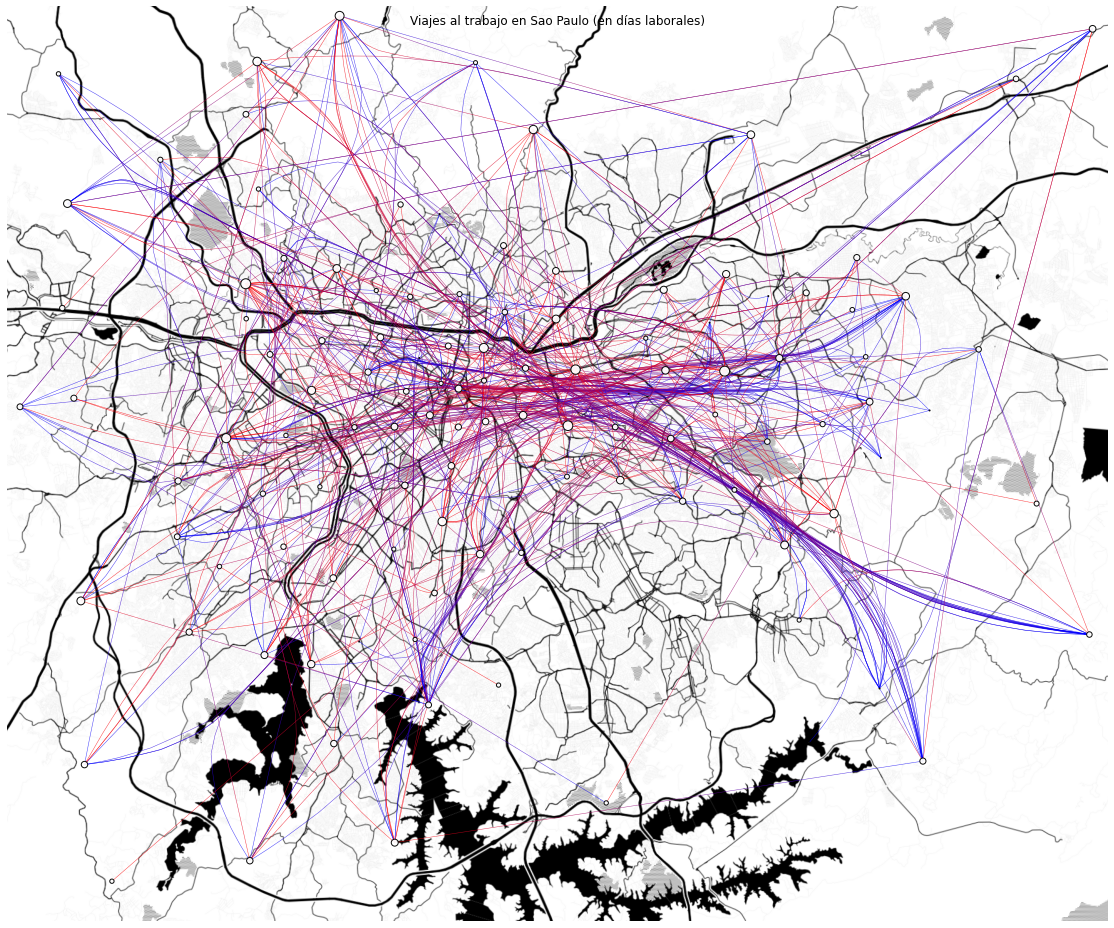

In [ ]:
grid = GeoFacetGrid(zonas_en_caja, height=13)
grid.add_basemap("saopaulo_toner_12.tif")
#grid.add_layer(city_shp_filt,facecolor='white', edgecolor='grey', alpha=0.25)
grid.add_layer(
    plot_network,
    nodes=dict(color="white", edgecolor="black", node_size=100, alpha=0.95),
    edges=dict(linewidth=0.5, alpha=0.75),
)
grid.set_title("Viajes al trabajo en Sao Paulo")